In [1]:
% pylab inline
import pandas as pd
import numpy as np

Populating the interactive namespace from numpy and matplotlib


In [2]:
train = pd.read_csv('train.csv')

In [3]:
train.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2011,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,01-01-2011,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,01-01-2011,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,01-01-2011,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,01-01-2011,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [4]:
train = train.drop('dteday', axis = 1)

In [5]:
train.head()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


# Tranformation of Data

## Checking the distribution of 'cnt'

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000020D8E3CF98>]],
      dtype=object)

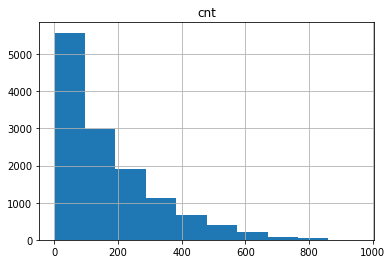

In [6]:
train.hist('cnt')

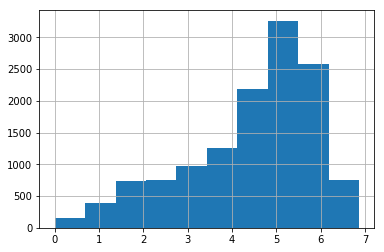

In [7]:
np.log(train.cnt).hist()

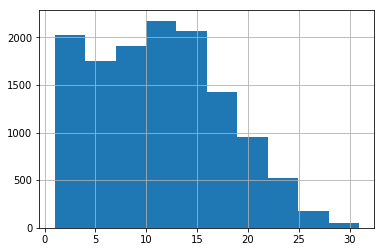

In [8]:
np.sqrt(train.cnt).hist()

It looks like a better distribution after taking the square root. I will be incorporating it in my model.

Since, the target variable is 'cnt' and not sqrt('cnt'), before looking at the predictions, we need to convert them back to orginal values of 'cnt' by squaring the predictions.

In [9]:
train['cnt'] = np.sqrt(train.cnt)

## Binning

In [10]:
train.groupby('hr')['cnt'].mean()

hr
0      6.421796
1      4.868380
2      3.914145
3      2.870303
4      2.217804
5      3.838930
6      7.460075
7     12.341031
8     16.570983
9     13.561476
10    11.849873
11    12.903466
12    14.280981
13    14.326265
14    13.906150
15    14.229268
16    15.987872
17    19.486232
18    18.718531
19    16.026949
20    13.632167
21    11.941526
22    10.436864
23     8.407402
Name: cnt, dtype: float64

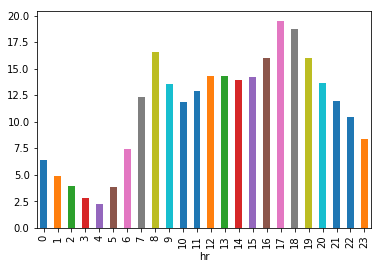

In [11]:
train.groupby('hr')['cnt'].mean().plot.bar()

In [12]:
# depending on the barchart, dividing dataset into 5 categories

train['hr_bins'] = pd.cut(train.hr, [-1, 6, 9, 15, 20, 24], labels = ['Late_Night', 'Office_Going', 
                                                                      'Mid_Day', 'Office_Returning', 'Night'])

In [13]:
display (train[['hr','hr_bins']][:24])

,hr,hr_bins
0,0,Late_Night
1,1,Late_Night
2,2,Late_Night
3,3,Late_Night
4,4,Late_Night
5,5,Late_Night
6,6,Late_Night
7,7,Office_Going
8,8,Office_Going
9,9,Office_Going


In [14]:
train['hr_bins'].value_counts()

Late_Night          3744
Mid_Day             3280
Office_Returning    2734
Office_Going        1639
Night               1638
Name: hr_bins, dtype: int64

We have binned according to the hourly distribution of count.

In [15]:
train['temp_bins'] = pd.cut(train.temp, [0, 0.3, 0.7, 1], labels = ['Low', 'Average', 'High'])
train['temp_bins'][:5]

0    Low
1    Low
2    Low
3    Low
4    Low
Name: temp_bins, dtype: category
Categories (3, object): [Low < Average < High]

In [16]:
train['temp_bins'].value_counts()

Average    8447
Low        2858
High       1730
Name: temp_bins, dtype: int64

Binning:
    1. Business Logic - if you want to target customers according to their age group
    2. Based on the trend seen in Data Exploration
    3. Based on relationship with target variable

# Feature/Variable Creation¶

In [17]:
train['weekend'] = ((train.holiday == 0) & (train.workingday == 0)).astype(int)

In [18]:
train['weekend'].value_counts()

0    9269
1    3766
Name: weekend, dtype: int64

### Label Encoding temp and hour

In [19]:
from sklearn.preprocessing import LabelEncoder

In [20]:
lb_temp = LabelEncoder()

train['temp_bins'] = lb_temp.fit_transform(train.temp_bins)

In [21]:
train['temp_bins'].value_counts()

0    8447
2    2858
1    1730
Name: temp_bins, dtype: int64

In [22]:
lb_hr = LabelEncoder()

train['hr_bins'] = lb_hr.fit_transform(train.hr_bins)

In [23]:
train['hr_bins'].value_counts()

0    3744
1    3280
4    2734
3    1639
2    1638
Name: hr_bins, dtype: int64

In alphabetical order

### Dummy for atemp

In [24]:
df = pd.cut(train.atemp, [0, 0.3, 0.7, 1], labels = ['atemp_low', 'atemp_avg', 'atemp_high'])
dummy = pd.get_dummies(df)
dummy[:5]

,atemp_low,atemp_avg,atemp_high
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0


In [25]:
train = pd.concat([train, dummy], axis = 1)

In [26]:
train[:5]

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,...,windspeed,casual,registered,cnt,hr_bins,temp_bins,weekend,atemp_low,atemp_avg,atemp_high
0,1,1,0,1,0,0,6,0,1,0.24,...,0.0,3,13,4.000000,0,2,1,1,0,0
1,2,1,0,1,1,0,6,0,1,0.22,...,0.0,8,32,6.324555,0,2,1,1,0,0
2,3,1,0,1,2,0,6,0,1,0.22,...,0.0,5,27,5.656854,0,2,1,1,0,0
3,4,1,0,1,3,0,6,0,1,0.24,...,0.0,3,10,3.605551,0,2,1,1,0,0
4,5,1,0,1,4,0,6,0,1,0.24,...,0.0,0,1,1.000000,0,2,1,1,0,0


In [27]:
train[['atemp', 'atemp_low', 'atemp_avg', 'atemp_high']]

# [0, 0.3, 0.7, 1], labels = ['atemp_low', 'atemp_avg', 'atemp_high']

,atemp,atemp_low,atemp_avg,atemp_high
0,0.2879,1,0,0
1,0.2727,1,0,0
2,0.2727,1,0,0
3,0.2879,1,0,0
4,0.2879,1,0,0
5,0.2576,1,0,0
6,0.2727,1,0,0
7,0.2576,1,0,0
8,0.2879,1,0,0
9,0.3485,0,1,0


Beware of running dummy concat code repeatedly, it will add extra columns

### Checking correlation

In [28]:
train.corr()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,...,windspeed,casual,registered,cnt,hr_bins,temp_bins,weekend,atemp_low,atemp_avg,atemp_high
instant,1.000000,0.111775,0.818586,0.156969,-0.007784,0.002583,0.001265,0.003200,-0.036729,0.164484,...,-0.029817,0.175793,0.272448,0.247821,-0.007691,-0.218367,-0.004214,-0.223279,0.210888,-0.013554
season,0.111775,1.000000,-0.398551,0.860652,-0.007900,-0.011476,-0.000899,0.010608,-0.013896,0.396799,...,-0.136074,0.105644,0.086086,0.117360,-0.007311,-0.281603,-0.006751,-0.366472,0.256510,0.139058
yr,0.818586,-0.398551,1.000000,-0.436539,-0.004738,-0.002220,-0.006967,-0.000151,-0.025445,-0.048912,...,0.054950,0.118124,0.213415,0.175967,-0.004404,-0.037445,0.000955,0.000525,0.038120,-0.069418
mnth,0.156969,0.860652,-0.436539,1.000000,-0.007193,0.006310,0.013697,0.005484,-0.014035,0.339578,...,-0.142520,0.072819,0.059485,0.085287,-0.006658,-0.280565,-0.007899,-0.352204,0.268472,0.094084
hr,-0.007784,-0.007900,-0.004738,-0.007193,1.000000,0.000445,-0.003644,0.002049,-0.026391,0.141782,...,0.137885,0.292431,0.381329,0.498872,0.663557,-0.042389,-0.002262,-0.096618,0.034713,0.096692
holiday,0.002583,-0.011476,-0.002220,0.006310,0.000445,1.000000,-0.105638,-0.246712,-0.018170,-0.026079,...,0.021764,0.028750,-0.046112,-0.028693,0.000394,0.047232,-0.106963,0.046108,-0.047561,0.010376
weekday,0.001265,-0.000899,-0.006967,0.013697,-0.003644,-0.105638,1.000000,0.035464,0.013678,-0.008367,...,0.000346,0.018091,0.019110,0.023853,-0.003183,-0.001275,0.001653,0.001696,0.000825,-0.005223
workingday,0.003200,0.010608,-0.000151,0.005484,0.002049,-0.246712,0.035464,1.000000,0.054980,0.051897,...,0.003324,-0.309414,0.129224,0.014515,0.001420,-0.067810,-0.937140,-0.069146,0.063229,0.000180
weathersit,-0.036729,-0.013896,-0.025445,-0.014035,-0.026391,-0.018170,0.013678,0.054980,1.000000,-0.095577,...,0.011307,-0.163177,-0.140289,-0.158685,-0.014805,-0.058460,-0.049865,-0.003219,0.055477,-0.095201
temp,0.164484,0.396799,-0.048912,0.339578,0.141782,-0.026079,-0.008367,0.051897,-0.095577,1.000000,...,-0.009291,0.460319,0.344653,0.428181,0.100685,-0.465164,-0.043855,-0.686841,0.371085,0.459257


In [29]:
train.corr()[((train.corr() < -0.85) | (train.corr() > 0.85)) & (train.corr() != 1)]

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,...,windspeed,casual,registered,cnt,hr_bins,temp_bins,weekend,atemp_low,atemp_avg,atemp_high
instant,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
season,NaN,NaN,NaN,0.860652,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
yr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mnth,NaN,0.860652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hr,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
holiday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
weekday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
workingday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.93714,NaN,NaN,NaN
weathersit,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
temp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


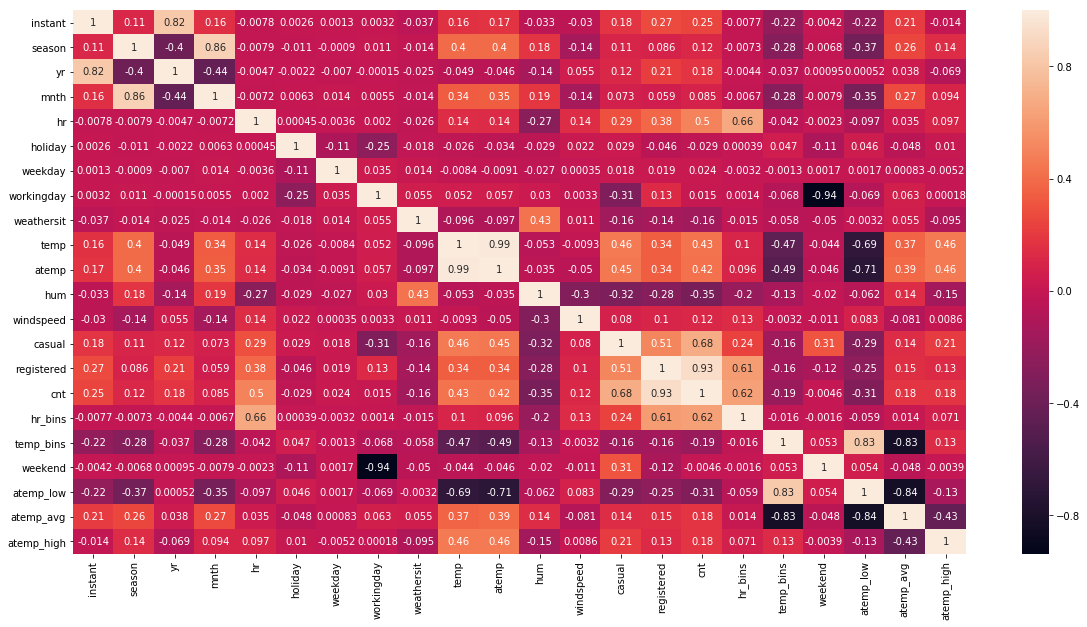

In [30]:
import seaborn as sns
corr = train.corr()
sns.heatmap(corr, xticklabels = corr.columns.values, yticklabels = corr.columns.values, 
            annot = True, annot_kws={'size':10})
heat_map=plt.gcf()
heat_map.set_size_inches(20,10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()